In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import callbacks, layers, ops
from tensorflow_probability.substrates.jax import distributions as tfd

In [2]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


def create_noisy_spiral(n, jitter_std=0.2, revolutions=2):
    angle = np.random.uniform(0, 2 * np.pi * revolutions, [n])
    r = angle

    x = r * np.cos(angle)
    y = r * np.sin(angle)

    result = np.stack([x, y], axis=1)
    result = result + np.random.normal(scale=jitter_std, size=[n, 2])
    result = 5 * normalize(result)
    return result

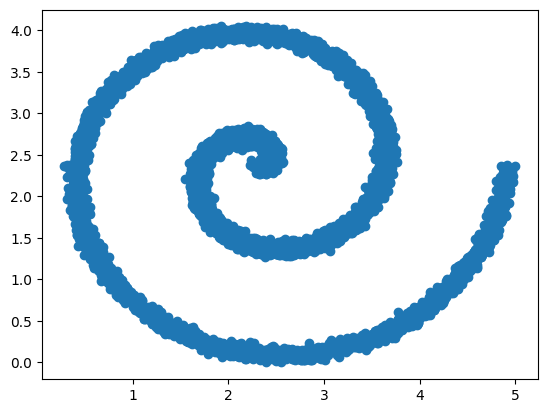

In [3]:
xy = create_noisy_spiral(10000)

x, y = xy[:, 0:1], xy[:, 1:]

plt.scatter(x, y)
plt.show()

In [4]:
N_HIDDEN = 128

model = keras.Sequential(
    [
        layers.Dense(N_HIDDEN, activation="relu"),
        layers.Dense(N_HIDDEN, activation="relu"),
        layers.Dense(1),
    ]
)

In [5]:
model.compile(optimizer="adam", loss="mse")

ERROR:2025-11-17 15:16:28,754:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/xy/Desktop/ml/TF/tf_2.20/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 197, in _version_check
    version = get_version()
RuntimeError: jaxlib/cuda/versions_helpers.cc:81: operation cusparseGetProperty(MAJOR_VERSION, &major) failed: The cuSPARSE library was not found.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/xy/Desktop/ml/TF/tf_2.20/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/xy/Desktop/ml/TF/tf_2.20/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 324, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/xy/Desktop/ml/TF/tf_2.20/lib/python3.10/site-packag

In [6]:
model.fit(
    x,
    y,
    epochs=300,
    batch_size=128,
    validation_split=0.15,
    callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=10)],
)

Epoch 1/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9631 - val_loss: 1.6225
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 1.4409 - val_loss: 1.2602
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 1.1081 - val_loss: 1.0394
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 1.0328 - val_loss: 1.0413
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 1.0292 - val_loss: 1.0342
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 1.0222 - val_loss: 1.0336
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 1.0212 - val_loss: 1.0353
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 1.0170 - val_loss: 1.0306
Epoch 9/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 1.0192 - val_loss: 1.0477
Epoch 10/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 1.0196 - val_loss: 1.0315
Epoch 11/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 1.0170 - val_loss: 1.0386
Epoch 12/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [7]:
y_pred = model.predict(x)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step


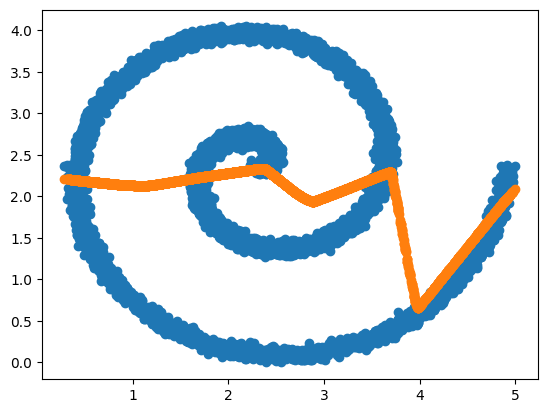

In [8]:
plt.scatter(x, y)
plt.scatter(x, y_pred)
plt.show()

In [9]:
def elu_plus_one_plus_epsilon(x):
    return keras.activations.elu(x) + 1 + keras.backend.epsilon()

In [10]:
class MixtureDensityOutput(layers.Layer):
    def __init__(self, output_dimension, num_mixtures, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        self.mdn_mus = layers.Dense(
            self.num_mix * self.output_dim, name="mdn_mus"
        )  # mix*output vals, no activation
        self.mdn_sigmas = layers.Dense(
            self.num_mix * self.output_dim,
            activation=elu_plus_one_plus_epsilon,
            name="mdn_sigmas",
        )  # mix*output vals exp activation
        self.mdn_pi = layers.Dense(self.num_mix, name="mdn_pi")  # mix vals, logits

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        super().build(input_shape)

    @property
    def trainable_weights(self):
        return (
            self.mdn_mus.trainable_weights
            + self.mdn_sigmas.trainable_weights
            + self.mdn_pi.trainable_weights
        )

    @property
    def non_trainable_weights(self):
        return (
            self.mdn_mus.non_trainable_weights
            + self.mdn_sigmas.non_trainable_weights
            + self.mdn_pi.non_trainable_weights
        )

    def call(self, x, mask=None):
        return layers.concatenate(
            [self.mdn_mus(x), self.mdn_sigmas(x), self.mdn_pi(x)], name="mdn_outputs"
        )

In [11]:
OUTPUT_DIMS = 1
N_MIXES = 20

mdn_network = keras.Sequential(
    [
        layers.Dense(N_HIDDEN, activation="relu"),
        layers.Dense(N_HIDDEN, activation="relu"),
        MixtureDensityOutput(OUTPUT_DIMS, N_MIXES),
    ]
)

In [12]:
def get_mixture_loss_func(output_dim, num_mixes):
    def mdn_loss_func(y_true, y_pred):
        # Reshape inputs in case this is used in a TimeDistributed layer
        y_pred = ops.reshape(y_pred, [-1, (2 * num_mixes * output_dim) + num_mixes])
        y_true = ops.reshape(y_true, [-1, output_dim])
        # Split the inputs into parameters
        out_mu, out_sigma, out_pi = ops.split(y_pred, 3, axis=-1)
        # Construct the mixture models
        cat = tfd.Categorical(logits=out_pi)
        mus = ops.split(out_mu, num_mixes, axis=1)
        sigs = ops.split(out_sigma, num_mixes, axis=1)
        coll = [
            tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)
            for loc, scale in zip(mus, sigs)
        ]
        mixture = tfd.Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = ops.negative(loss)
        loss = ops.mean(loss)
        return loss

    return mdn_loss_func


mdn_network.compile(loss=get_mixture_loss_func(OUTPUT_DIMS, N_MIXES), optimizer="adam")

In [13]:
mdn_network.fit(
    x,
    y,
    epochs=300,
    batch_size=128,
    validation_split=0.15,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.0396 - val_loss: 1.6054 - learning_rate: 0.0010
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.5294 - val_loss: 1.4970 - learning_rate: 0.0010
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1.4362 - val_loss: 1.4167 - learning_rate: 0.0010
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 1.3792 - val_loss: 1.3688 - learning_rate: 0.0010
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.3353 - val_loss: 1.3480 - learning_rate: 0.0010
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 1.3122 - val_loss: 1.3034 - learning_rate: 0.0010
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1.2907 - val_loss: 1.2779 - learning_rate: 0.0010
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 1.2775 - val_loss: 1.2590 - learning_rate: 0.0010
Epoch 9/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 1.2526 - val_loss: 1.2456 - learning_rate: 0.0010
Ep

In [14]:
y_pred_mixture = mdn_network.predict(x)
print(y_pred_mixture.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
(10000, 60)


In [15]:
def split_mixture_params(params, output_dim, num_mixes):
    mus = params[: num_mixes * output_dim]
    sigs = params[num_mixes * output_dim : 2 * num_mixes * output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    e = np.array(w) / t  # adjust temperature
    e -= e.max()  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e)
    return dist


def sample_from_categorical(dist):
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    print("Error sampling categorical model.")
    return -1


def sample_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m * output_dim : (m + 1) * output_dim]
    sig_vector = sigs[m * output_dim : (m + 1) * output_dim]
    scale_matrix = np.identity(output_dim) * sig_vector  # scale matrix from diag
    cov_matrix = np.matmul(scale_matrix, scale_matrix.T)  # cov is scale squared.
    cov_matrix = cov_matrix * sigma_temp  # adjust for sigma temperature
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

In [16]:
# Sample from the predicted distributions
y_samples = np.apply_along_axis(
    sample_from_output, 1, y_pred_mixture, 1, N_MIXES, temp=1.0
)

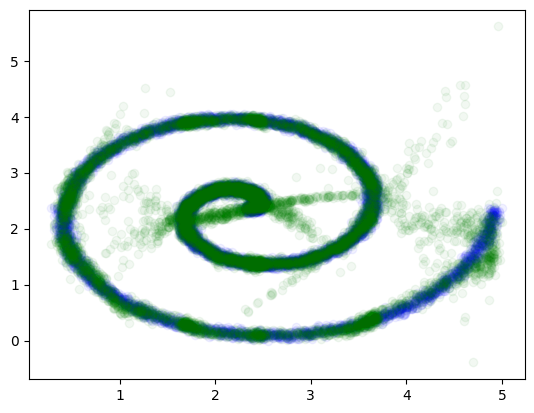

In [17]:
plt.scatter(x, y, alpha=0.05, color="blue", label="Ground Truth")
plt.scatter(
    x,
    y_samples[:, :, 0],
    color="green",
    alpha=0.05,
    label="Mixture Density Network prediction",
)
plt.show()

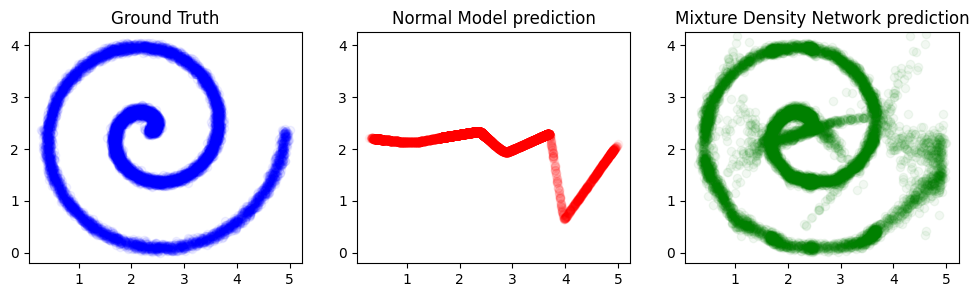

In [18]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(3)
fig.set_figwidth(12)
axs[0].set_title("Ground Truth")
axs[0].scatter(x, y, alpha=0.05, color="blue")
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

axs[1].set_title("Normal Model prediction")
axs[1].scatter(x, y_pred, alpha=0.05, color="red")
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[2].scatter(
    x,
    y_samples[:, :, 0],
    color="green",
    alpha=0.05,
    label="Mixture Density Network prediction",
)
axs[2].set_title("Mixture Density Network prediction")
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)
plt.show()